# Automatic Image Captioning

--------------------------------
## Install additional libraries

In [ ]:
from IPython.display import clear_output
!pip install -q rouge-score
clear_output()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from os.path import exists
import re
import string
import torch
import torch.nn as nn
from torch.autograd import Variable
import cv2
import torchvision
from torch.utils.data import DataLoader, random_split
from torchtext.data.metrics import bleu_score
from rouge_score import rouge_scorer
from collections import Counter
from tqdm import tqdm
import pickle
import nltk
from nltk.translate.bleu_score import sentence_bleu

import warnings
warnings.filterwarnings(action='ignore')

nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Check for GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load captions from dataset

In [ ]:
df = pd.read_csv('captions.txt', delimiter=',', dtype={'caption': str})
df.columns = ['image_name','comment']
print(df.shape)
df.head()

(40455, 2)


,image_name,comment
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Preprocessing of captions

### Text cleaning

In [ ]:


regex = re.compile('[%s]' % re.escape(string.punctuation))
def clean_text(row):
    row = str(row).strip()
    row = row.lower()
    return regex.sub("", row)

with tqdm(total=len(df['comment'].values)) as progress_bar:
    for i, caption in enumerate(df['comment'].values):
        newcaption = clean_text(caption)
        df['comment'].iloc[i] = newcaption
        progress_bar.update(1)
df['comment']

100%|██████████| 40455/40455 [00:16<00:00, 2421.37it/s]


0        a child in a pink dress is climbing up a set o...
1                     a girl going into a wooden building 
2          a little girl climbing into a wooden playhouse 
3        a little girl climbing the stairs to her playh...
4        a little girl in a pink dress going into a woo...
                               ...                        
40450             a man in a pink shirt climbs a rock face
40451              a man is rock climbing high in the air 
40452    a person in a red shirt climbing up a rock fac...
40453                       a rock climber in a red shirt 
40454    a rock climber practices on a rock climbing wall 
Name: comment, Length: 40455, dtype: object

### EDA of vocabulary

Vocabulary Size: 8828


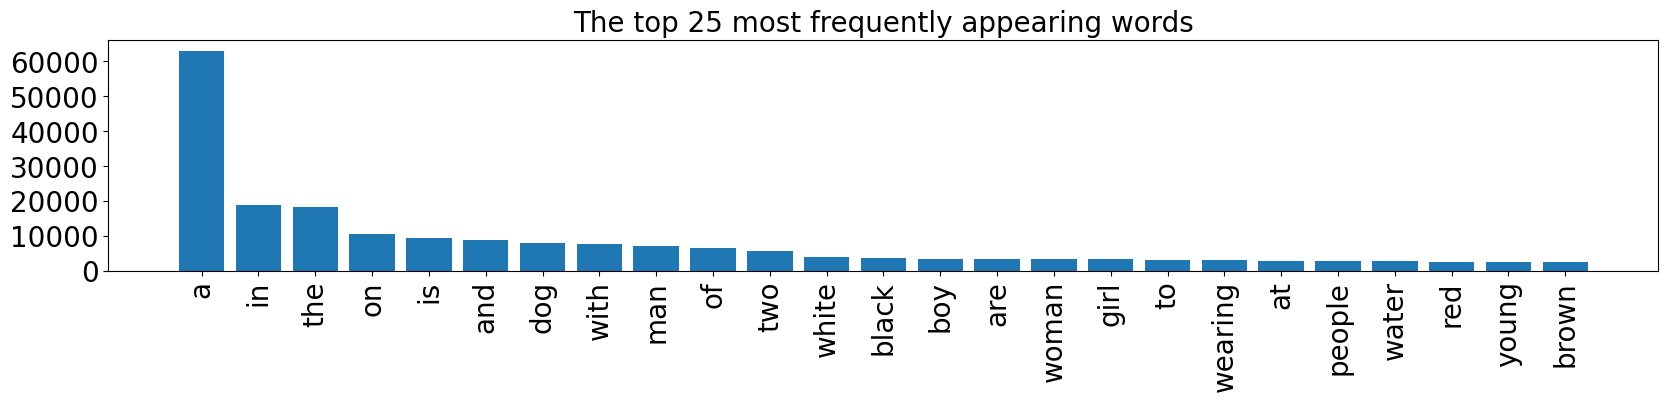

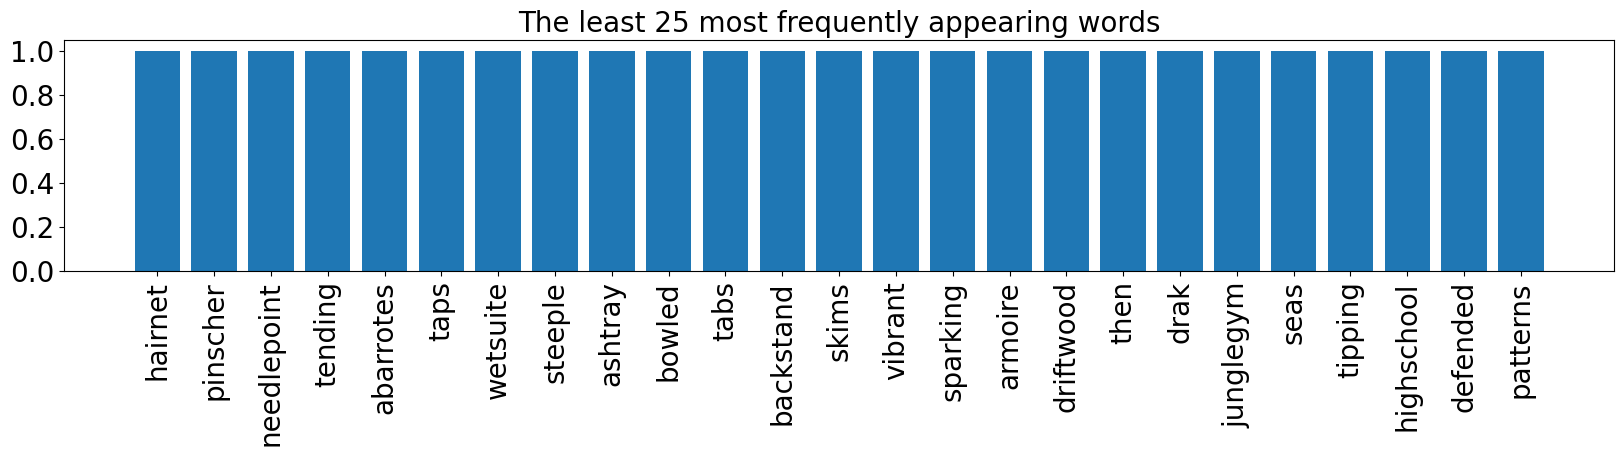

In [ ]:
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i]
        vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    del vocabulary
    return dfword

dfword = df_word(df['comment'])

topn = 25

def plthist(dfsub, title="The top {} most frequently appearing words".format(topn)):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top {} most frequently appearing words".format(topn))
plthist(dfword.iloc[-topn:,:],
        title="The least {} most frequently appearing words".format(topn))

### Create word frequency

In [ ]:
word_freq = {}
for caption in df['comment']:
    caption = caption.strip()
    for word in caption.split():
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

### Build vocabulary

In [ ]:
def build_vocab(captions, word_freq, count_threshold=5):

    vocab = {
        "<pad>": 0,
        "<unk>": 1,
        "<sos>": 2,
        "<eos>": 3
    }
    index = 4

    for caption in captions:
        caption = caption.strip().split(" ")
        for word in caption:
            if word and word_freq[word] >= count_threshold and word not in vocab:
                vocab[word] = index
                index += 1

    inv_vocab = {v: k for k, v in vocab.items()}
    return vocab, inv_vocab

vocab, inv_vocab = build_vocab(df['comment'], word_freq)
print("Vocabulary size: {}".format(len(vocab)))

Vocabulary size: 2995


### Tokenize words into indices

In [ ]:
max_sen_len = 14
def convert_captions(captions, vocab, max_length=max_sen_len+2):
    tokens = [[vocab["<pad>"]]*max_length for _ in range(len(captions))]
    for i, caption in enumerate(captions):
        caption = caption.strip().split()
        tokens[i][0] = vocab["<sos>"]
        j = 1
        for word in caption[:max_length-2]:
            if word not in vocab:
                tokens[i][j] = vocab["<unk>"]
            else:
                tokens[i][j] = vocab[word]
            j += 1
        tokens[i][j] = vocab["<eos>"]
    return tokens
df['comment'] = convert_captions(df['comment'], vocab)
df.head()

,image_name,comment
0,1000268201_693b08cb0e.jpg,"[2, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14..."
1,1000268201_693b08cb0e.jpg,"[2, 4, 17, 18, 19, 4, 20, 21, 3, 0, 0, 0, 0, 0..."
2,1000268201_693b08cb0e.jpg,"[2, 4, 22, 17, 10, 19, 4, 20, 23, 3, 0, 0, 0, ..."
3,1000268201_693b08cb0e.jpg,"[2, 4, 22, 17, 10, 24, 14, 25, 26, 23, 3, 0, 0..."
4,1000268201_693b08cb0e.jpg,"[2, 4, 22, 17, 6, 4, 7, 8, 18, 19, 4, 20, 1, 3..."


## Build Image Caption Dataset Class and helper functions

In [ ]:
class ImageCaptionDataset(torch.utils.data.Dataset):
    """Image Caption Dataset - Flickr 30k Dataset"""

    def __init__(self, root_dir, df_csv, transform=None):
          on a sample.

            Returns the number of examples in dataset.


In [ ]:
def unnormalizeImage(img):

    if torch.is_tensor(img):
        img = img.cpu().detach().clone().numpy()

    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.transpose((1, 2, 0))

    return img

### Generate dataset

In [ ]:
IMGPATH = "../input/flickr8k/Images"

TRANSFORM_IMG = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
flickr_dataset = ImageCaptionDataset(root_dir=IMGPATH, df_csv=df, transform=TRANSFORM_IMG)
flickr_dataset

### Train-Dev-Test split

In [ ]:
BATCH_SIZE = 100
NUM_WORKERS = 0

n_val = int(np.floor(0.05 * len(flickr_dataset)))
n_test = int(np.floor(0.05 * len(flickr_dataset)))
n_train = len(flickr_dataset) - n_val - n_test
dl_args = dict(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

train_ds, val_ds, test_ds = random_split(flickr_dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(20))

train_dl = DataLoader(train_ds, **dl_args)
valid_dl = DataLoader(val_ds, **dl_args)
test_dl = DataLoader(test_ds, **dl_args)

print("no of batches in train set: {}".format(len(train_dl)))
print("no of batches in valid set: {}".format(len(valid_dl)))
print("no of batches in test set: {}".format(len(test_dl)))

no of batches in train set: 365
no of batches in valid set: 21
no of batches in test set: 21


## Build Model

The block diagram of model is shown below:

![Image Caption Model - Block Diagram](attachment:16932c49-e15a-4847-bf74-991dcb10158a.png)

### Image Encoder Class

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, hidd_dim):
        super().__init__()
        self.cnn = torch.nn.Sequential(*(list(torchvision.models.resnet101(pretrained=True).children())[:-1]),
                                      nn.Flatten())
        self.cnn.eval()
        self.fc = nn.Linear(2048, hidd_dim)

    def forward(self, img):
        img = self.cnn(img)
        img = self.fc(img)
        return img

### Caption Decoder Class

In [ ]:
class CaptionDecoder(nn.Module):
    def __init__(self, n_vocab, hidd_dim, max_sen_len, emb_dim, p):
        super().__init__()
        self.max_sen_len = max_sen_len
        self.emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=emb_dim, padding_idx=0)

        self.lstm = nn.LSTM(input_size=emb_dim,
                            hidden_size=hidd_dim,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False,
                            dropout=p)
        self.fc_text = nn.Linear(hidd_dim, n_vocab)
        self.soft = nn.Softmax(dim=-1)

    def forward(self, x, img, predict_mode=False):
        img = torch.stack([img]*(self.lstm.num_layers), dim=0).to(device)
        if predict_mode:
            output = []
            h0 = img
            c0 = img
            while x != vocab["<eos>"] and len(output) <= self.max_sen_len:
                x = torch.tensor([[x]]).to(device)
                x = self.emb(x)
                out, (h0, c0) = self.lstm(x, (h0, c0))
                out = self.fc_text(out)
                out = self.soft(out)
                out = torch.argmax(out, dim=-1)
                x = out.squeeze().item()
                output.append(x)
            output = torch.tensor(output).to(device)
        else:
            x = self.emb(x)
            output, (h0, c0) = self.lstm(x, (img, img))
            output = self.fc_text(output)
        return output

### Image Caption Model Class

In [ ]:
class ImgCaptionModel(nn.Module):
    def __init__(self, n_vocab, hidd_dim, max_sen_len, emb_dim, p=0):
        super().__init__()
        self.encoder = ImageEncoder(hidd_dim).to(device)
        self.decoder = CaptionDecoder(n_vocab, hidd_dim, max_sen_len, emb_dim, p).to(device)

    def predict(self, img):
        img = self.encoder(img)
        cap = vocab["<sos>"]
        yhat = self.decoder(cap, img, predict_mode=True)

        pred_sen = [inv_vocab[t.item()] for t in yhat]
        pred_sen = " ".join(pred_sen)
        return pred_sen

    def forward(self, sample):
        '''
            sample: dict of image & caption
        '''
        img = sample['image'].to(device)
        cap = sample['caption'].to(device)

        '''---For Image---'''
        img = self.encoder(img)

        '''---For Text---'''
        yhat = self.decoder(cap[:, :-1], img, predict_mode=False)
        yhat = yhat.permute(0, 2, 1)
        return yhat

### Define helper functions

In [ ]:
def train(model, sample, loss_fn, optimizer):
    model.train()

    cap = sample['caption'].to(device)
    yhat = model(sample)

    loss = loss_fn(yhat, cap[:,1:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def test(model, sample, i, loss_fn):
    model.eval()
    with torch.no_grad():
        cap = sample['caption'].to(device)
        yhat = model(sample)
        loss = loss_fn(yhat, cap[:,1:])

    return loss.item()

def predict(model, sample, i, plot_img=False):
    model.eval()
    with torch.no_grad():
        img = sample['image'][i].to(device)
        if plot_img:
            plt.imshow(unnormalizeImage(img))
            plt.xticks([])
            plt.yticks([])
            plt.show()
        pred_sen = model.predict(img.unsqueeze(0))

    return pred_sen

def sample_output(model, ds=test_ds):
    with torch.no_grad():
        j = np.random.randint(low=0,high=len(ds))
        img = ds[j]['image']
        true_ans = ds[j]['caption']
        sp = {'image': img.unsqueeze(0), 'caption':true_ans.unsqueeze(0)}
        pred_ans = predict(model, sp, 0, plot_img=True)

        true_ans = [inv_vocab[t.item()] for t in true_ans if t not in [0,2,3]]
        rc = [true_ans]
        true_ans = " ".join(true_ans)
        print("true: {}".format(true_ans))
        print("prediction: {}".format(pred_ans))

        #bleu scores
        cc = pred_ans.split(' ')
        cc = [ps for ps in cc if ps not in ['<sos>', '<eos>', '<pad>']]
        b1 = sentence_bleu(rc,cc,weights=(1,0,0,0))
        b2 = sentence_bleu(rc,cc,weights=(0.5,0.5,0,0))
        b3 = sentence_bleu(rc,cc,weights=(1/3,1/3,1/3,0))
        b4 = sentence_bleu(rc,cc,weights=(0.25, 0.25, 0.25, 0.25))
        print("BLEU-1: {:.2f}\nBLEU-2: {:.2f}\nBLEU-3: {:.2f}\nBLEU-4: {:.2f}".format(b1,b2,b3,b4))


        #rouge scores
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        pred_ans = pred_ans.split(' ')
        pred_ans = " ".join([p for p in pred_ans if p not in ['<sos>', '<eos>', '<pad>']])
        r = scorer.score(true_ans,pred_ans)
        r1 = r['rouge1']
        r2 = r['rouge2']
        rl = r['rougeL']
        print("ROUGE-1: {}\nROUGE-2: {}\nROUGE-l: {}".format(r1,r2,rl))

        #meteor scores
        m1 = nltk.translate.meteor_score.meteor_score([[true_ans]],[pred_ans])
        print("METEOR: {:.2f}".format(m1))

## Training the Model

In [ ]:
model = ImgCaptionModel(n_vocab=len(vocab), hidd_dim=512, max_sen_len=max_sen_len+2, emb_dim=32, p=0).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 30
print(model)

ImgCaptionModel(
  (encoder): ImageEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [ ]:
train_loss = []
valid_loss = []
B1 = []
B2 = []
B3 = []
B4 = []
R1 = []
R2 = []
RL = []
M = []
best_loss = torch.inf
best_model = dict()

for i in range(epochs):
    '''
        Training on train set
    '''
    print("--- Epoch {} ---".format(i+1))
    epoch_loss = 0
    m = len(train_dl)
    with tqdm(total=m) as progress_bar:
        for sample in train_dl:
            epoch_loss += train(model, sample, loss_fn, optimizer)
            progress_bar.update(1)
    print("\tLoss (Training) : {}".format(epoch_loss/m))
    train_loss.append(epoch_loss/m)

    '''
        Testing on dev set
    '''
    val_loss = 0
    with tqdm(total=len(valid_dl)) as progress_bar1:
        for j in range(len(valid_dl)):
            vl = test(model, sample, j, loss_fn)
            if vl < best_loss:
                best_loss = vl
                best_model = model.state_dict()
            val_loss+=vl
            progress_bar1.update(1)
    print("\tLoss (Validation) : {}".format(val_loss/len(valid_dl)))
    valid_loss.append(val_loss/len(valid_dl))

    '''
        Computing sentence generation metrics on dev set
    '''
    with tqdm(total=len(val_ds)) as progress_bar2:
        for j in range(len(val_ds)):
            with torch.no_grad():
                img = val_ds[j]['image']
                true_ans = val_ds[j]['caption']
                sp = {'image': img.unsqueeze(0), 'caption':true_ans.unsqueeze(0)}
                pred_ans = predict(model, sp, 0)

                true_ans = [inv_vocab[t.item()] for t in true_ans if t not in [0,2,3]]
                rc = [true_ans]
                true_ans = " ".join(true_ans)

                #bleu scores
                cc = pred_ans.split(' ')
                cc = [ps for ps in cc if ps not in ['<sos>', '<eos>', '<pad>']]
                b1 = sentence_bleu(rc,cc,weights=(1,0,0,0))
                b2 = sentence_bleu(rc,cc,weights=(0.5,0.5,0,0))
                b3 = sentence_bleu(rc,cc,weights=(1/3,1/3,1/3,0))
                b4 = sentence_bleu(rc,cc,weights=(0.25, 0.25, 0.25, 0.25))
                B1.append(b1)
                B2.append(b2)
                B3.append(b3)
                B4.append(b4)

                #rouge scores
                scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
                pred_ans = pred_ans.split(' ')
                pred_ans = " ".join([p for p in pred_ans if p not in ['<sos>', '<eos>', '<pad>']])
                r = scorer.score(true_ans,pred_ans)
                r1 = r['rouge1']
                r2 = r['rouge2']
                rl = r['rougeL']
                R1.append(r1.fmeasure)
                R2.append(r2.fmeasure)
                RL.append(rl.fmeasure)

                #meteor scores
                m1 = nltk.translate.meteor_score.meteor_score([[true_ans]],[pred_ans])
                M.append(m1)
            progress_bar2.update(1)

NameError: name 'torch' is not defined

## Save results & best model

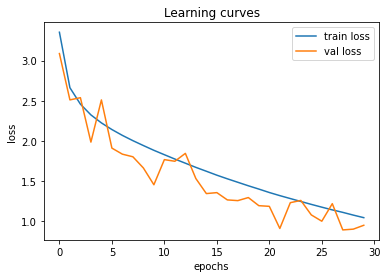

In [ ]:
plt.plot(range(len(train_loss)),train_loss, label='train loss')
plt.plot(range(len(valid_loss)),valid_loss, label='val loss')
plt.title("Learning curves")
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
torch.save(best_model, 'best_model_weights8k.h5')
print("Weights of best model saved successfully!")

Weights of best model saved successfully!


In [ ]:
def process_results(res):
    r = []
    m = int(res.shape[0]/epochs)
    for i in range(epochs):
        r.append(res[i*m:(i+1)*m].to_numpy())
    r = np.array(r).mean(axis=1)
    return r

df_metrics = pd.DataFrame({
    'B1':B1,
    'B2':B2,
    'B3':B3,
    'B4':B4,
    'R1':R1,
    'R2':R2,
    'RL':RL,
    'M':M
})
df_metrics = df_metrics.apply(process_results,axis=0)*100
df_metrics.to_csv('results8k.csv', index=False)

df_loss = pd.DataFrame({
    'train_loss':train_loss,
    'valid_loss':valid_loss
})
df_loss = df_loss.apply(process_results,axis=0)
df_loss.to_csv('loss8k.csv', index=False)
print("Results saved successfully!")

Results saved successfully!


### Plot results

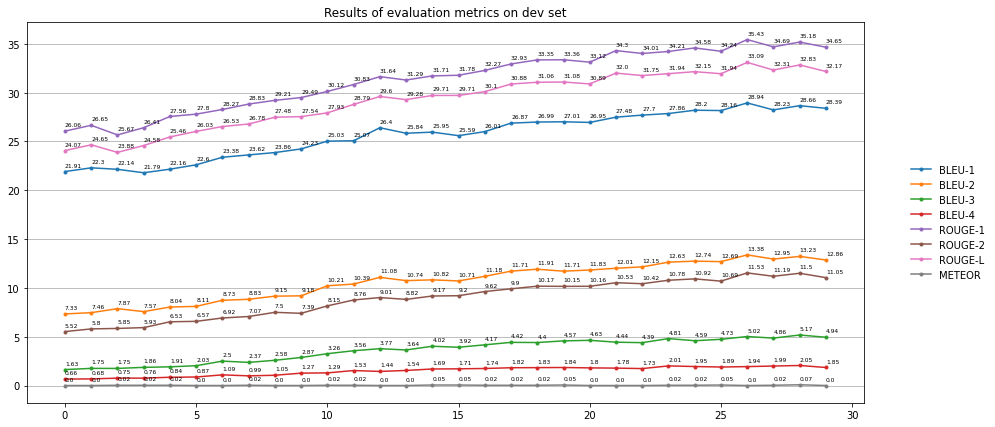

In [ ]:
x = range(epochs)
plt.figure(figsize=(15,7))
plt.plot(x, df_metrics['B1'], label='BLEU-1', marker='.')
plt.plot(x, df_metrics['B2'], label='BLEU-2', marker='.')
plt.plot(x, df_metrics['B3'], label='BLEU-3', marker='.')
plt.plot(x, df_metrics['B4'], label='BLEU-4', marker='.')
plt.plot(x, df_metrics['R1'], label='ROUGE-1', marker='.')
plt.plot(x, df_metrics['R2'], label='ROUGE-2', marker='.')
plt.plot(x, df_metrics['RL'], label='ROUGE-L', marker='.')
plt.plot(x, df_metrics['M'], label='METEOR', marker='.')
plt.title("Results of evaluation metrics on dev set")
plt.legend(loc='lower center', bbox_to_anchor=(1.1, 0.3), ncol=1).get_frame().set_linewidth(0.0)
plt.grid(axis='y')

for c in df_metrics.columns.tolist():
    for idx,val in enumerate(df_metrics[c].to_numpy()):
        plt.text(idx,val+0.5, str(np.round_(val,2)), color='black', fontsize=6)
plt.show()

## Generate sample outputs from test set using best weights

In [ ]:
bestmodel = ImgCaptionModel(n_vocab=len(vocab), hidd_dim=512, max_sen_len=16, emb_dim=32, p=0).to(device)
bestmodel.load_state_dict(torch.load('./best_model_weights8k.h5'))
print("Best weights loaded successfully!")

Best weights loaded successfully!


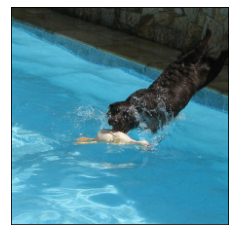

true: a dog is jumping into a swimming pool after a duck
prediction: a black dog jumps into a swimming pool <eos>
BLEU-1: 0.52
BLEU-2: 0.39
BLEU-3: 0.33
BLEU-4: 0.26
ROUGE-1: Score(precision=0.875, recall=0.6363636363636364, fmeasure=0.7368421052631579)
ROUGE-2: Score(precision=0.5714285714285714, recall=0.4, fmeasure=0.47058823529411764)
ROUGE-l: Score(precision=0.875, recall=0.6363636363636364, fmeasure=0.7368421052631579)
METEOR: 0.00


In [ ]:
sample_output(bestmodel)

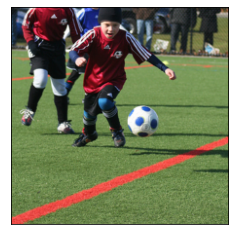

true: boys wearing hats play in a soccer game
prediction: two boys are playing soccer <eos>
BLEU-1: 0.22
BLEU-2: 0.00
BLEU-3: 0.00
BLEU-4: 0.00
ROUGE-1: Score(precision=0.6, recall=0.375, fmeasure=0.4615384615384615)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-l: Score(precision=0.6, recall=0.375, fmeasure=0.4615384615384615)
METEOR: 0.00


In [ ]:
sample_output(bestmodel)